In [ ]:
from etl.extractor import OverpassQuarryExtractor
from etl.pipeline import ETLPipeline

In [7]:
extractor = OverpassQuarryExtractor("PT")
gdf = extractor.run()
gdf.head(2)

📡 Extraindo dados para PT...
✅ 956 pedreiras carregadas.


,abandoned,abandoned:landuse,addr:city,addr:postcode,addr:street,alt_name,archaeological_site,area,basin,description,disused,disused:landuse,geological,geological:site,industrial,landuse,layer,man_made,name,natural,note,official_name,old_name,opening_hours,operator,product,ref,ref:source,resource,short_name,source,source:geometry:date,source:geometry:description,source:geometry:id,source:geometry:ref,state,tourism,water,website,wikidata,geometry
0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,quarry,None,None,Pedreira da Barragem de Odeleite,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"POLYGON ((-7.48169 37.32554, -7.48108 37.32567..."
1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,quarry,None,None,Pedreiras de Mármore,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"POLYGON ((-7.57417 38.83473, -7.57343 38.83425..."


In [9]:
pipeline = ETLPipeline(extractor)

In [21]:
caminho = r"C:\Users\brisk\OneDrive\Área de Trabalho\Douglas\Scaffolding\scaffold\etl\outputs\meuarquivo.geojson"
caminho = caminho.replace('\\', '/')
caminho

'C:/Users/brisk/OneDrive/Área de Trabalho/Douglas/Scaffolding/scaffold/etl/outputs/meuarquivo.geojson'

In [22]:
pipeline.run(caminho)

🔍 Extraindo dados...
📡 Extraindo dados para PT...
✅ 956 pedreiras carregadas.
🛠️ Transformando dados...
💾 Salvando dados transformados em: C:/Users/brisk/OneDrive/Área de Trabalho/Douglas/Scaffolding/scaffold/etl/outputs/meuarquivo.geojson
🏁 ETL finalizado com sucesso. Total de feições: 956


In [24]:
import geopandas as gpd

gdf = gpd.read_file(caminho)
gdf.head()

,landuse,operator,industrial,man_made,name,tipo,geometry
0,quarry,None,None,None,Pedreira da Barragem de Odeleite,pedreira,"POLYGON ((-7.48169 37.32554, -7.48108 37.32567..."
1,quarry,None,None,None,Pedreiras de Mármore,pedreira,"POLYGON ((-7.57417 38.83473, -7.57343 38.83425..."
2,quarry,None,None,None,Tecnovia,pedreira,"POLYGON ((-8.21005 37.13943, -8.21026 37.13952..."
3,quarry,None,None,None,Pedreira do Moinho,pedreira,"POLYGON ((-8.64038 41.12405, -8.64214 41.12351..."
4,quarry,None,None,None,Pedreira de Adaufe,pedreira,"POLYGON ((-8.41604 41.57448, -8.41566 41.57459..."


In [ ]:
import geopandas as gpd

# Load your GeoJSON
gdf = gpd.read_file("bahia_quarry.geojson")

# Simplify geometries (tolerance in degrees for EPSG:4326)
tolerance = 0.0005  # try 0.0005 or 0.01 depending on detail needed
gdf["geometry"] = gdf["geometry"].simplify(tolerance, preserve_topology=True)

# Save to new simplified file (optional)
gdf.to_file("bahia_quarry_simplified.geojson", driver="GeoJSON")

In [ ]:
gdf = gpd.read_file("quarries_for_training.gpkg")
gdf

In [ ]:
gdf = gdf[['quarry_id', 'landuse', 'status', 'land_situation', 'geometry']]
gdf.to_file("quarries_for_training_2.gpkg")

In [ ]:
gdf

In [ ]:
new_gdf = gdf[['quarry_id',	'landuse',	'status',	'land_situation']]
new_gdf.to_csv('quarries.csv')

In [ ]:
# Projeto completo: Classificação de áreas de mineração com DINOv2
# Estrutura:
# 1. Gerar patches das imagens com base no CSV de rótulo
# 2. Extrair embeddings com DINOv2
# 3. Treinar classificador com embeddings
# 4. Avaliar e salvar resultados

# ==============================
# 1. GERAR PATCHES
# ==============================

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from dinov2.models import build_model
from types import SimpleNamespace
import numpy as np
from tqdm import tqdm
from torchvision.io import read_image
from torchvision import transforms
import torch
import os
import pandas as pd
from PIL import Image
from pathlib import Path


def gerar_patches(csv_path, input_folder, output_folder, patch_size=512):
    input_folder = Path(input_folder)
    output_folder = Path(output_folder)
    output_folder.mkdir(parents=True, exist_ok=True)

    labels_df = pd.read_csv(csv_path)
    labels_df = labels_df.drop(columns=["Unnamed: 0"], errors="ignore")

    patches_data = []

    for img_file in input_folder.glob("*.png"):
        quarry_id = img_file.stem
        row = labels_df[labels_df["quarry_id"] == quarry_id]
        if row.empty:
            continue

        land_situation = row.iloc[0]["land_situation"]

        with Image.open(img_file) as img:
            width, height = img.size
            for i in range(0, width - patch_size + 1, patch_size):
                for j in range(0, height - patch_size + 1, patch_size):
                    patch = img.crop((i, j, i + patch_size, j + patch_size))
                    patch_filename = f"{quarry_id}_{i}_{j}.png"
                    patch_path = output_folder / patch_filename
                    patch.save(patch_path)

                    patches_data.append({
                        "filename": patch_filename,
                        "land_situation": land_situation
                    })

    patches_df = pd.DataFrame(patches_data)
    patches_df.to_csv(output_folder / "patch_labels.csv", index=False)
    print(f"✅ Patches salvos em: {output_folder}")


def extrair_embeddings_dino(patches_dir, csv_file, output_file):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define os argumentos esperados pelo build_model
    args = SimpleNamespace(
        arch="vit_small",
        patch_size=14,
        layerscale=None,
        ffn_layer="mlp",
        block_chunks=0,
        qkv_bias=True,
        proj_bias=True,
        ffn_bias=True,
        num_register_tokens=0,
        interpolate_offset=False,
        interpolate_antialias=False,
        drop_path_rate=0.0,
        drop_path_uniform=False
    )

    # Constrói o modelo e seleciona o student
    student, teacher, embed_dim = build_model(args)
    model = student.to(device)
    model.eval()

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    df = pd.read_csv(csv_file)
    embeddings = []
    labels = []

    for _, row in tqdm(df.iterrows(), total=len(df)):
        img_path = os.path.join(patches_dir, row['filename'])
        if not os.path.exists(img_path):
            print(f"⚠️ Arquivo não encontrado: {img_path}")
            continue
        img = read_image(img_path)
        img = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            features = model.forward_features(img)
            emb = features['x_norm_clstoken'].cpu().numpy().flatten()

        embeddings.append(emb)
        labels.append(row['land_situation'])

    np.savez(output_file, embeddings=embeddings, labels=labels)
    print(f"✅ Embeddings salvos em: {output_file}.npz")


# ==============================
# 3. TREINAR CLASSIFICADOR
# ==============================


def treinar_classificador(npz_path):
    data = np.load(npz_path, allow_pickle=True)
    X = data['embeddings']
    y_raw = ["{}__{}".format(*lbl) for lbl in data['labels']]

    le = LabelEncoder()
    y = le.fit_transform(y_raw)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42)

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    print("\n📊 Relatório de Classificação:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    return clf, le


# ==============================
# 4. EXEMPLO DE EXECUÇÃO
# ==============================

gerar_patches(
    csv_path=r"K:\Quarry\dados\quarries.csv",
    input_folder=r"K:\Quarry\dados\images",
    output_folder=r"K:\Quarry\dados\patches",
    patch_size=512
)

folder = r"K:\Quarry\dados\patches"

for file in os.listdir(folder):
    if file.endswith(".png"):
        path = os.path.join(folder, file)
        img = Image.open(path)
        if img.mode == 'RGBA':
            img = img.convert('RGB')
            img.save(path)


extrair_embeddings_dino(
    patches_dir=r"K:\Quarry\dados\patches",
    csv_file=r"K:\Quarry\dados\patches\patch_labels.csv",
    output_file=r"K:\Quarry\dados\embeddings"
)

treinar_classificador(r"K:\Quarry\dados\embeddings.npz")

✅ Patches salvos em: K:\Quarry\dados\patches


  0%|          | 0/1126 [00:00<?, ?it/s]k:\Quarry\.venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 1126/1126 [00:51<00:00, 21.75it/s]


✅ Embeddings salvos em: K:\Quarry\dados\embeddings.npz

📊 Relatório de Classificação:
              precision    recall  f1-score   support

        a__b       0.53      0.78      0.63       106
        a__c       0.54      0.41      0.46        54
        c__l       0.25      0.05      0.08        21
        i__n       0.29      0.16      0.20        45

    accuracy                           0.50       226
   macro avg       0.40      0.35      0.34       226
weighted avg       0.46      0.50      0.45       226



(LogisticRegression(max_iter=1000), LabelEncoder())

In [ ]:
# Projeto completo: Classificação de áreas de mineração com DINOv2

# ==============================
# 1. GERAR PATCHES
# ==============================

from dinov2.models import build_model
from types import SimpleNamespace
import numpy as np
from tqdm import tqdm
from torchvision.io import read_image
from torchvision import transforms
import torch
import os
import pandas as pd
from PIL import Image
from pathlib import Path


def gerar_patches(csv_path, input_folder, output_folder, patch_size=256):
    input_folder = Path(input_folder)
    output_folder = Path(output_folder)
    output_folder.mkdir(parents=True, exist_ok=True)

    labels_df = pd.read_csv(csv_path)
    labels_df = labels_df.drop(columns=["Unnamed: 0"], errors="ignore")

    patches_data = []

    for img_file in input_folder.glob("*.png"):
        quarry_id = img_file.stem
        row = labels_df[labels_df["quarry_id"] == quarry_id]
        if row.empty:
            continue

        land_situation = row.iloc[0]["land_situation"]

        with Image.open(img_file) as img:
            width, height = img.size
            for i in range(0, width - patch_size + 1, patch_size):
                for j in range(0, height - patch_size + 1, patch_size):
                    patch = img.crop((i, j, i + patch_size, j + patch_size))
                    patch_filename = f"{quarry_id}_{i}_{j}.png"
                    patch_path = output_folder / patch_filename
                    patch.save(patch_path)

                    patches_data.append({
                        "filename": patch_filename,
                        "land_situation": land_situation
                    })

    patches_df = pd.DataFrame(patches_data)
    patches_df.to_csv(output_folder / "patch_labels.csv", index=False)
    print(f"✅ Patches salvos em: {output_folder}")


# ==============================
# 2. EXTRAIR EMBEDDINGS COM DINOv2
# ==============================


def extrair_embeddings_dino(patches_dir, csv_file, output_file):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    args = SimpleNamespace(
        arch="vit_small",
        patch_size=14,
        layerscale=None,
        ffn_layer="mlp",
        block_chunks=0,
        qkv_bias=True,
        proj_bias=True,
        ffn_bias=True,
        num_register_tokens=0,
        interpolate_offset=False,
        interpolate_antialias=False,
        drop_path_rate=0.0,
        drop_path_uniform=False
    )

    student, teacher, embed_dim = build_model(args)
    model = student.to(device)
    model.eval()

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    df = pd.read_csv(csv_file)
    embeddings = []
    labels = []

    for _, row in tqdm(df.iterrows(), total=len(df)):
        img_path = os.path.join(patches_dir, row['filename'])
        if not os.path.exists(img_path):
            print(f"⚠️ Arquivo não encontrado: {img_path}")
            continue
        img = read_image(img_path)
        img = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            features = model.forward_features(img)
            emb = features['x_norm_clstoken'].cpu().numpy().flatten()

        embeddings.append(emb)
        # Garantir que seja string pura
        labels.append(str(row['land_situation']))

    np.savez(output_file, embeddings=embeddings, labels=labels)
    print(f"✅ Embeddings salvos em: {output_file}.npz")

In [ ]:

# ==============================
# 3. TREINAR CLASSIFICADOR
# ==============================

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


def treinar_classificador(npz_path):
    data = np.load(npz_path, allow_pickle=True)
    X = data['embeddings']
    y_raw = [str(lbl) for lbl in data['labels']]  # <-- Corrigido aqui

    le = LabelEncoder()
    y = le.fit_transform(y_raw)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )

    clf = LogisticRegression(max_iter=5000)  # Aumenta max_iter
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    print("\n📊 Relatório de Classificação:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    return clf, le, y_test, y_pred

In [ ]:

# ==============================
# 4. EXECUÇÃO COMPLETA
# ==============================

# 1. Gerar patches
gerar_patches(
    csv_path=r"dados\quarries.csv",
    input_folder=r"K:\Quarry\dados\images",
    output_folder=r"K:\Quarry\dados\patches",
    patch_size=256
)

# 2. Corrigir imagens RGBA para RGB
folder = r"K:\Quarry\dados\patches"
for file in os.listdir(folder):
    if file.endswith(".png"):
        path = os.path.join(folder, file)
        img = Image.open(path)
        if img.mode == 'RGBA':
            img = img.convert('RGB')
            img.save(path)

✅ Patches salvos em: K:\Quarry\dados\patches


In [ ]:

# 3. Extrair embeddings
extrair_embeddings_dino(
    patches_dir=r"K:\Quarry\dados\patches",
    csv_file=r"K:\Quarry\dados\patches\patch_labels.csv",
    output_file=r"K:\Quarry\dados\embeddings"
)

  0%|          | 0/6756 [00:00<?, ?it/s]k:\Quarry\.venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 6756/6756 [04:20<00:00, 25.91it/s]

✅ Embeddings salvos em: K:\Quarry\dados\embeddings.npz


In [ ]:

# 4. Treinar classificador
treinar_classificador(r"K:\Quarry\dados\embeddings.npz")


📊 Relatório de Classificação:
              precision    recall  f1-score   support

   abandoned       0.52      0.85      0.65       632
      active       0.46      0.37      0.41       322
      closed       0.55      0.09      0.15       127
    inactive       0.28      0.05      0.09       271

    accuracy                           0.50      1352
   macro avg       0.45      0.34      0.32      1352
weighted avg       0.46      0.50      0.43      1352



(LogisticRegression(max_iter=5000),
 LabelEncoder(),
 array([1, 1, 3, ..., 3, 0, 0], dtype=int64),
 array([0, 0, 0, ..., 1, 0, 0], dtype=int64))

In [ ]:
clf, label_encoder, y_test, y_pred = treinar_classificador(
    "dados/embeddings.npz")


📊 Relatório de Classificação:
              precision    recall  f1-score   support

   abandoned       0.52      0.85      0.65       632
      active       0.46      0.37      0.41       322
      closed       0.55      0.09      0.15       127
    inactive       0.28      0.05      0.09       271

    accuracy                           0.50      1352
   macro avg       0.45      0.34      0.32      1352
weighted avg       0.46      0.50      0.43      1352



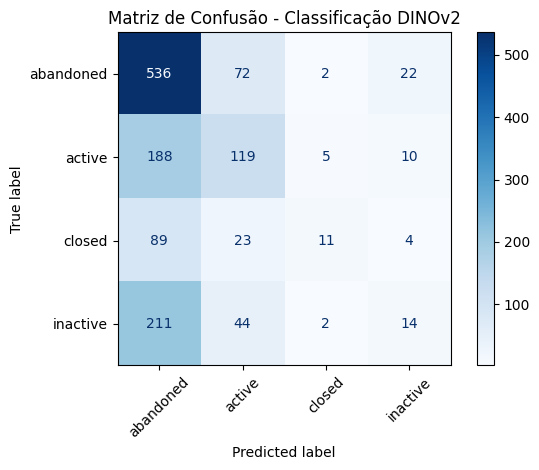

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
labels = label_encoder.classes_

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Matriz de Confusão - Classificação DINOv2")
plt.tight_layout()
plt.show()

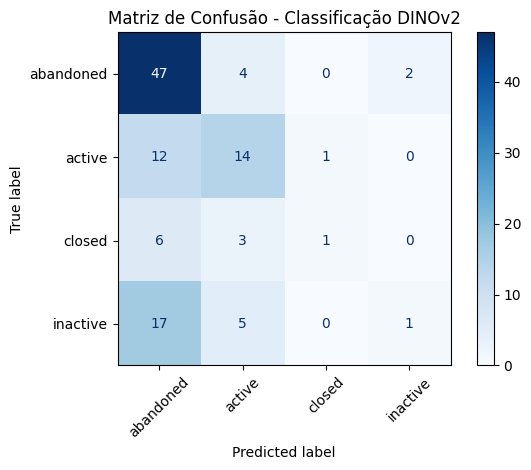

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
labels = label_encoder.classes_

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Matriz de Confusão - Classificação DINOv2")
plt.tight_layout()
plt.show()

In [67]:
seilah

NameError: name 'seilah' is not defined

In [ ]:
# Carrega e agrupa as classes menos frequentes
df = pd.read_csv("dados/quarries.csv")

# Agrupar 'closed', 'inactive', 'unknown', 'past_producer' em 'other'
df['land_situation'] = df['land_situation'].replace({
    'closed': 'inactive/closed/abandoned',
    'abandoned': 'inactive/closed/abandoned',
})

# Salva novo CSV com classes agrupadas
df.to_csv("dados/quarries_agrupado.csv", index=False)
print("✅ Classes agrupadas salvas em 'quarries_agrupado.csv'")

✅ Classes agrupadas salvas em 'quarries_agrupado.csv'


In [ ]:
from torchvision import transforms
from PIL import Image
import os
from pathlib import Path

augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
])


def aumentar_patches(input_folder, labels_csv, output_folder, n_aug=3):
    df = pd.read_csv(labels_csv)
    output_folder = Path(output_folder)
    novas_linhas = []

    for _, row in df.iterrows():
        if row['land_situation'] != 'other':
            continue

        img_path = os.path.join(input_folder, row['filename'])
        if not os.path.exists(img_path):
            continue

        img = Image.open(img_path)
        for i in range(n_aug):
            aug_img = augmentations(img)
            new_filename = row['filename'].replace(".png", f"_aug{i}.png")
            aug_img.save(output_folder / new_filename)

            novas_linhas.append({
                "filename": new_filename,
                "land_situation": "other"
            })

    # Adiciona os novos exemplos ao CSV
    df_aug = pd.DataFrame(novas_linhas)
    df_final = pd.concat([df, df_aug], ignore_index=True)
    df_final.to_csv(output_folder / "patch_labels_augmentado.csv", index=False)
    print("✅ Augmentações salvas e CSV atualizado com patches aumentados.")

In [ ]:
aumentar_patches(
    input_folder=r'K:\Quarry\dados\patches',
    labels_csv=r'K:\Quarry\dados\patches\patch_labels.csv',
    output_folder=r'K:\Quarry\dados\patches',
    n_aug=3  # ou mais, se quiser aumentar o balanceamento
)